# Sheet 8

In [2]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from tqdm import tqdm

## 1) Anomaly detection for Autoencoders

In [3]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
# import wget
# from zipfile import ZipFile
# from tqdm import tqdm

# DESTINATION = "data06"
# url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
# filename = "toptagging-short.zip"
# url = url + filename

# os.makedirs(DESTINATION, exist_ok=True)
# os.chdir(DESTINATION)
# wget.download(url, filename)
# with ZipFile(filename, "r") as zip_ref:
#     for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
#         zip_ref.extract(member=file)
# os.chdir("..")
# %ls data06

In [4]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [5]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [6]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
print(z_train.shape)
print(z_val.shape)
print(z_test.shape)

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
(30000, 1, 40, 40)
(30000, 1, 40, 40)
(30000, 1, 40, 40)


(a)

In [47]:
# TODO: Construct autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        dense1 = nn.Linear(1600, 512)
        dense2 = nn.Linear(512, 256)
        dense3 = nn.Linear(256, 128)
        dense4 = nn.Linear(128, 64)
        # dense5 = nn.Linear(64, 10)

        # rev_dense1 = nn.Linear(10, 64)
        rev_dense2 = nn.Linear(64, 128)
        rev_dense3 = nn.Linear(128, 256)
        rev_dense4 = nn.Linear(256, 512)
        rev_dense5 = nn.Linear(512, 1600)

        self.encoder = nn.Sequential(
            nn.Flatten(1, 3),
            dense1,
            nn.ReLU(),
            dense2,
            nn.ReLU(),
            dense3,
            nn.ReLU(),
            dense4,
            nn.ReLU(),
            # dense5,
            # nn.ReLU(),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            # rev_dense1,
            # nn.ReLU(),
            rev_dense2,
            nn.ReLU(),
            rev_dense3,
            nn.ReLU(),
            rev_dense4,
            nn.ReLU(),
            rev_dense5,
            nn.ReLU(),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

<span style="color:green">Ho aggiunto la mia implementazione dell'Autoencoder, per ogni layer usa lo steso numero di neuroni, non va a diminuendo
</span>

In [ ]:
class AUTOENCODER(nn.Module):
    def __init__(self,input_size = 1600,bottleneck_size = 15,hidden_size = 3,layers=2):
        super().__init__()
        self.input_size=input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers
        
    
        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()
        
        self.encoder_layers.append(nn.Linear(input_size,hidden_size))
        self.encoder_output = nn.Linear(hidden_size,bottleneck_size)
        
        self.decoder_layers.append(nn.Linear(bottleneck_size,hidden_size))
        self.decoder_output = nn.Linear(hidden_size,input_size)
        
        for i in range(1,self.layers):
            self.encoder_layers.append(nn.Linear(hidden_size,hidden_size))
            self.decoder_layers.append(nn.Linear(hidden_size,hidden_size))
        
        
    def forward(self,x):
        for i in range(self.layers):
            x = F.relu(self.encoder_layers[i](x))
            
        x = self.encoder_output(x)
        
        for i in range(self.layers):
            x = F.relu(self.decoder_layers[i](x))
            
        x = self.decoder_output(x)
        return x
    
    
    def forward_encoder(self,x):
        for i in range(self.layers):
            x = F.relu(self.encoder_layers[i](x))
            
        x = self.encoder_output(x)
        return x
    
    
    def forward_decoder(self,x):
        for i in range(self.layers):
            x = F.relu(self.decoder_layers[i](x))
            
        x = self.decoder_output(x)
        return x

<span style="color:green">La mia funzione di training, 3 epoche sono troppo poche fratm
</span>

In [ ]:
def train_autoencoder(model, x_train, epochs = 200, learning_rate = 0.001):
    error = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    losses = []

    for i in tqdm(range(epochs)):
        x_pred = model.forward(x_train)
        loss = error(x_pred,x_train)
        losses.append(loss.detach().numpy())
        if(i % 5 == 0):
            #print(f'epoch: {i}, loss: {losses[i]:3f}')
            #plt.scatter(i,losses[i],color='black')
        plt.plot(losses)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    plt.title(f'error losses as a function of epochs with hidden_size: {model.hidden_size}, layers: {model.layers}, test_size: {x_train.detach().numpy().size}, learning_rate: {learning_rate}')
    plt.xlabel("Epochs")
    plt.ylabel("Reconstruction error")
    plt.show()

(b)

In [54]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20
qcd_jets = z_train[ np.where(y_train==0) ]
qcd_jets_tensor = torch.tensor(qcd_jets.astype(np.float32))
# batch_size = int(qcd_jets_original.shape[0] / 5)
max_epochs = 3
autoencoder = Autoencoder()

# trainloader = torch.utils.data.DataLoader(qcd_jets_original.astype(np.float32), batch_size=batch_size, shuffle=False)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

for epoch in range(0, max_epochs):
    print(f"Starting epoch {epoch + 1}")
    optimizer.zero_grad()

    outputs = autoencoder(qcd_jets_tensor)
    reshaped_outputs = outputs.reshape(qcd_jets_tensor.shape)

    loss = loss_function(reshaped_outputs, qcd_jets_tensor)
    loss.backward()
    optimizer.step()
    print(loss.item())




    # for i, data in enumerate(trainloader, 0):
    #     optimizer.zero_grad()
        
    #     outputs = autoencoder(data)
    #     reshaped_outputs = outputs.reshape(batch_size, 1, 40, 40)

    #     loss = loss_function(reshaped_outputs, data)
        
    #     loss.backward()
        
    #     optimizer.step()
        
    #     current_loss += loss.item()
    # print(current_loss)

Starting epoch 1
0.2531023919582367
Starting epoch 2
0.2528705894947052
Starting epoch 3
0.2526576817035675


(c)

<span style="color:green"> Definisco il mio Autoencoder
</span>

In [ ]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20
qcd_jets = z_train[ np.where(y_train==0) ]
qcd_jets_tensor = torch.tensor(qcd_jets.astype(np.float32))

model = AUTOENCODER(1600,15,1600,2)

<span style="color:green">Non ho runnato ma questa sotto ci mette almeno 10 minuti, e sicuro ho sbagliato tra tensor e numpy
</span>

In [ ]:
train_autoencoder(model,qcd_jets)

<span style="color:green">Sto facendo sicuro un casino con i dati ma questo sotto è il testing
</span>

In [ ]:
qcd_jets_original = z_test[ np.where(y_train==0) ]

with torch.no_grad():
    synthetic_data = model.forward(torch.tensor(qcd_jets_original.astype(np.float32)))

criterion = nn.MSELoss()
error = criterion(synthetic_data,torch.tensor(qcd_jets_original.astype(np.float32)))

error

<span style="color:green">E qui genera un immagine di QCD. Ho fatto sicuro un casino me ne rendo conto, carico su github anche il mio codice, io ad esempio i z_train, z_test e z_val me li trasformo prima in un array (30000,1600) sia per QCD che per top e poi all'uscita dell'autoencoder faccio il reshape
</span>

In [ ]:
qcd_jets_val = z_val[ np.where(y_train==0) ]

with torch.no_grad():
    prova = model.forward(qcd_jets_val.astype(np.float32))

plt.imshow(prova[90].reshape(40,40), cmap = 'Reds')

/var/folders/r8/x2t3wbfj7_xd0x651mkgmdqc0000gn/T/ipykernel_665/2439340602.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


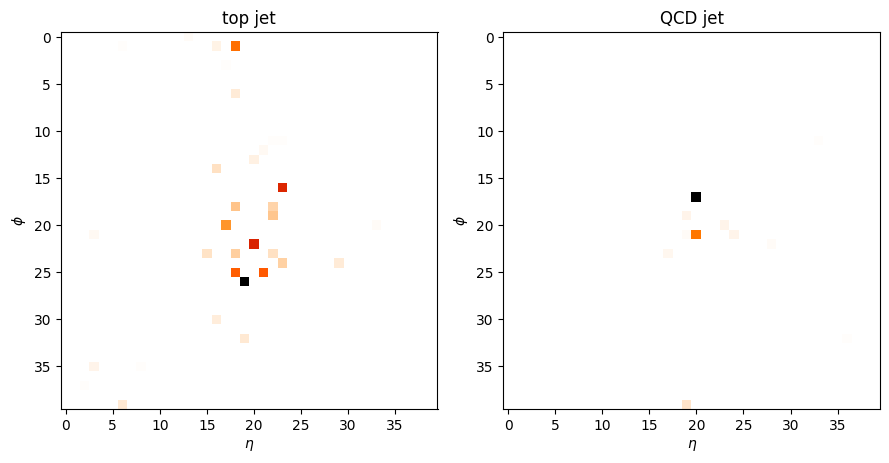

In [55]:
# TODO: Visualize original vs reconstructed QCD and top jets

final_outputs = autoencoder(torch.tensor(z_test.astype(np.float32))).reshape(30000, 1, 40, 40)
final_outputs = final_outputs.detach().numpy()

top_jets_original = z_test[ np.where(y_train==1) ]
qcd_jets_original = z_test[ np.where(y_train==0) ]

fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( top_jets_original[0,0,...], cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("top jet")

axs[1].imshow( qcd_jets_original[0,0,...], cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("QCD jet")

fig.tight_layout()

fig.show()

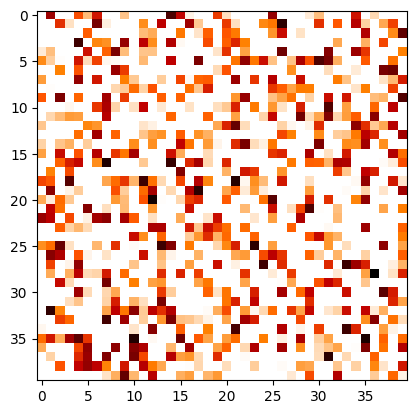

In [56]:
for i in range(final_outputs.shape[0]):
    if i % 2000 == 0:
        plt.imshow(final_outputs[i][0], cmap="gist_heat_r")
plt.show()

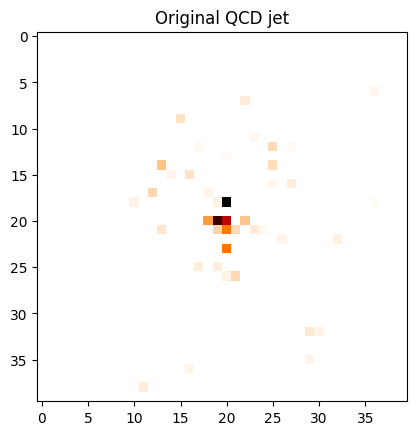

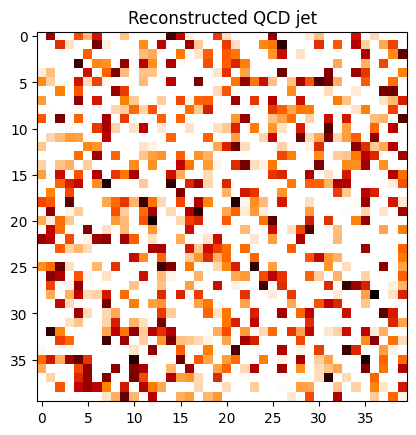

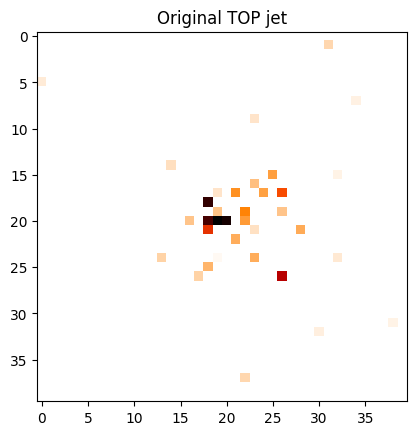

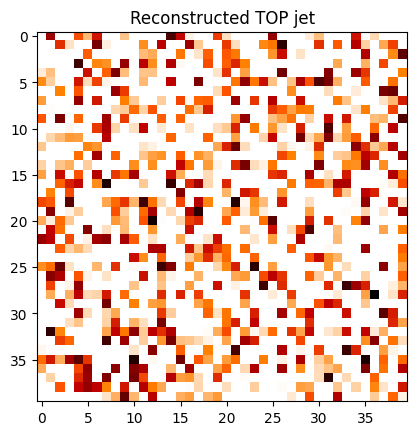

In [57]:
top_jets = final_outputs[ np.where(y_test==1) ]
qcd_jets = final_outputs[ np.where(y_test==0) ]

plt.imshow(qcd_jets_original[11][0], cmap="gist_heat_r")
plt.title("Original QCD jet")
plt.show()
plt.imshow(qcd_jets[11][0], cmap="gist_heat_r")
plt.title("Reconstructed QCD jet")
plt.show()
plt.imshow(top_jets_original[90][0], cmap="gist_heat_r")
plt.title("Original TOP jet")
plt.show()
plt.imshow(top_jets[90][0], cmap="gist_heat_r")
plt.title("Reconstructed TOP jet")
plt.show()

(d)

In [12]:
# TODO: Visualize pixel-wise MSE, plot ROC


(e)

In [13]:
# TODO: Repeat everything for CNN

(f)

In [14]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN